In [1]:
import numpy as np
import glob
import nibabel as nib
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage import measure

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Add
from tensorflow.keras.layers import Concatenate, Activation
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import RandomNormal

In [2]:
# loss for discriminator
def accw(y_true, y_pred):
    y_pred=K.clip(y_pred, -1, 1)
    return K.mean(K.equal(y_true, K.round(y_pred)))

# loss for generator to find structured similarity between images
def mssim(y_true, y_pred):
    costs = 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))
    return costs

# loss for generator
def wloss(y_true,y_predict):
    return -K.mean(y_true*y_predict)

In [3]:
def discriminator(inp_shape = (256,256,1), trainable = True):
    gamma_init = RandomNormal(1., 0.02)
    
    inp = Input(shape = (256,256,1))
    
    l0 = Conv2D(64, (4,4), strides = (2,2), padding = 'same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(inp) #b_init is set to none, maybe they are not using bias here, but I am.
    l0 = LeakyReLU(alpha=0.2)(l0)
    
    l1 = Conv2D(64*2, (4,4), strides = (2,2), padding = 'same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(l0)
    l1 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l1)
    l1 = LeakyReLU(alpha=0.2)(l1)
    
    l2 = Conv2D(64*4, (4,4), strides = (2,2), padding = 'same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(l1)
    l2 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l2)
    l2 = LeakyReLU(alpha=0.2)(l2)
    
    l3 = Conv2D(64*8, (4,4), strides = (2,2), padding = 'same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(l2)
    l3 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l3)
    l3 = LeakyReLU(alpha=0.2)(l3)
    
    l4 = Conv2D(64*16, (4,4), strides = (2,2), padding = 'same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(l3)
    l4 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l4)
    l4 = LeakyReLU(alpha=0.2)(l4)
    
    l5 = Conv2D(64*32, (4,4), strides = (2,2), padding = 'same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(l4)
    l5 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l5)
    l5 = LeakyReLU(alpha=0.2)(l5)
    
    l6 = Conv2D(64*16, (1,1), strides = (1,1), padding = 'same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(l5)
    l6 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l6)
    l6 = LeakyReLU(alpha=0.2)(l6)
    
    l7 = Conv2D(64*8, (1,1), strides = (1,1), padding = 'same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(l6)
    l7 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l7)
    l7 = LeakyReLU(alpha=0.2)(l7)
    #x
    
    l8 = Conv2D(64*2, (1,1), strides = (1,1), padding = 'same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(l7)
    l8 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l8)
    l8 = LeakyReLU(alpha=0.2)(l8)
    
    l9 = Conv2D(64*2, (3,3), strides = (1,1), padding = 'same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(l8)
    l9 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l9)
    l9 = LeakyReLU(alpha=0.2)(l9)
    
    l10 = Conv2D(64*8, (3,3), strides = (1,1), padding = 'same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(l9)
    l10 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l10)
    l10 = LeakyReLU(alpha=0.2)(l10)
    #y
    l11 = Add()([l7,l10])
    l11 = LeakyReLU(alpha = 0.2)(l11)
    
    out=Conv2D(filters=1,kernel_size=3,strides=1,padding='same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(l11)
    model = Model(inputs = inp, outputs = out)
    return model

In [4]:
# RRDB (residual in residual dense block at bottom of unet to increase depth of network)
def resden(x,fil,gr,beta,gamma_init,trainable):   
    # concatentations create residual connections between consecutive blocks
    x1=Conv2D(filters=gr,kernel_size=3,strides=1,padding='same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(x)
    x1=BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(x1)
    x1=LeakyReLU(alpha=0.2)(x1)
    
    x1=Concatenate(axis=-1)([x,x1])
    
    x2=Conv2D(filters=gr,kernel_size=3,strides=1,padding='same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(x1)
    x2=BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(x2)
    x2=LeakyReLU(alpha=0.2)(x2)

    x2=Concatenate(axis=-1)([x1,x2])
        
    x3=Conv2D(filters=gr,kernel_size=3,strides=1,padding='same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(x2)
    x3=BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(x3)
    x3=LeakyReLU(alpha=0.2)(x3)

    x3=Concatenate(axis=-1)([x2,x3])
    
    x4=Conv2D(filters=gr,kernel_size=3,strides=1,padding='same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(x3)
    x4=BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(x4)
    x4=LeakyReLU(alpha=0.2)(x4)

    x4=Concatenate(axis=-1)([x3,x4])
    
    x5=Conv2D(filters=fil,kernel_size=3,strides=1,padding='same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(x4)
    x5=Lambda(lambda x:x*beta)(x5)
    xout=Add()([x5,x])
    
    return xout

In [5]:
def resresden(x,fil,gr,betad,betar,gamma_init,trainable):
    x1=resden(x,fil,gr,betad,gamma_init,trainable)
    x2=resden(x1,fil,gr,betad,gamma_init,trainable)
    x3=resden(x2,fil,gr,betad,gamma_init,trainable)
    x3=Lambda(lambda x:x*betar)(x3)
    xout=Add()([x3,x])
    
    return xout

In [6]:
def generator(inp_shape, trainable = True): 
    gamma_init = RandomNormal(1., 0.02)

    fd=512
    gr=32
    nb=12
    betad=0.2
    betar=0.2
    
    ## contracting phase in unet 
    inp_real_imag = Input(inp_shape)
    lay_128dn = Conv2D(64, (4,4), strides = (2,2), padding = 'same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(inp_real_imag)

    lay_128dn = LeakyReLU(alpha = 0.2)(lay_128dn)

    lay_64dn = Conv2D(128, (4,4), strides = (2,2), padding = 'same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(lay_128dn)
    lay_64dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_64dn)
    lay_64dn = LeakyReLU(alpha = 0.2)(lay_64dn)

    lay_32dn = Conv2D(256, (4,4), strides = (2,2), padding = 'same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(lay_64dn)
    lay_32dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_32dn)
    lay_32dn = LeakyReLU(alpha=0.2)(lay_32dn)

    lay_16dn = Conv2D(512, (4,4), strides = (2,2), padding = 'same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(lay_32dn)
    lay_16dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_16dn)
    lay_16dn = LeakyReLU(alpha=0.2)(lay_16dn)  #16x16 

    lay_8dn = Conv2D(512, (4,4), strides = (2,2), padding = 'same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(lay_16dn)
    lay_8dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_8dn)
    lay_8dn = LeakyReLU(alpha=0.2)(lay_8dn) #8x8


    xc1=Conv2D(filters=fd,kernel_size=3,strides=1,padding='same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(lay_8dn) #8x8
    xrrd=xc1
    
    ## bottle neck with RRDbs
    # add residual connections between pairs of blocks
    for m in range(nb):
        xrrd=resresden(xrrd,fd,gr,betad,betar,gamma_init,trainable)

    xc2=Conv2D(filters=fd,kernel_size=3,strides=1,padding='same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(xrrd)
    lay_8upc=Add()([xc1,xc2])

    ## expansion phase in unet
    lay_16up = Conv2DTranspose(1024, (4,4), strides = (2,2), padding = 'same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(lay_8upc)
    lay_16up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_16up)
    lay_16up = Activation('relu')(lay_16up) #16x16

    lay_16upc = Concatenate(axis = -1)([lay_16up,lay_16dn])

    lay_32up = Conv2DTranspose(256, (4,4), strides = (2,2), padding = 'same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(lay_16upc) 
    lay_32up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_32up)
    lay_32up = Activation('relu')(lay_32up) #32x32

    lay_32upc = Concatenate(axis = -1)([lay_32up,lay_32dn])

    lay_64up = Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(lay_32upc)
    lay_64up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_64up)
    lay_64up = Activation('relu')(lay_64up) #64x64

    lay_64upc = Concatenate(axis = -1)([lay_64up,lay_64dn])

    lay_128up = Conv2DTranspose(64, (4,4), strides = (2,2), padding = 'same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(lay_64upc)
    lay_128up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_128up)
    lay_128up = Activation('relu')(lay_128up) #128x128

    lay_128upc = Concatenate(axis = -1)([lay_128up,lay_128dn])

    lay_256up = Conv2DTranspose(64, (4,4), strides = (2,2), padding = 'same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(lay_128upc)
    lay_256up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_256up)
    lay_256up = Activation('relu')(lay_256up) #256x256

    out =  Conv2D(1, (1,1), strides = (1,1), activation = 'tanh', padding = 'same', use_bias = True, kernel_initializer = 'he_normal', bias_initializer = 'zeros')(lay_256up)

    model = Model(inputs = inp_real_imag, outputs = out)

    return model

In [15]:
def define_gan_model(gen_model, dis_model, inp_shape):
    dis_model.trainable = False
    inp = Input(shape = inp_shape)
    out_g = gen_model(inp)
    out_dis = dis_model(out_g)
    out_g1 = out_g
    model = Model(inputs = inp, outputs = [out_dis, out_g, out_g1])
    #model.summary()
    return model

In [91]:
def plot_reconstructed_img(model, gen_inp, real):
    uns = gen_inp[0][:, :, 0]
    ground_truth = real[0][:, :, 0]
    reconstructed = model.predict(gen_inp)[0]
    print(reconstructed[0][:, :, 0].shape)
    plt.imshow(reconstructed[0][:, :, 0])
    plt.show()
    
    

In [67]:
# Hyperparameters       
n_epochs = 1 # orig 300
n_batch = 2 # orig 32
n_critic = 3
clip_val = 0.05
in_shape_gen = (256,256,2)
in_shape_dis = (256,256,1)
accel = 3

d_model = discriminator(inp_shape = in_shape_dis, trainable = True)
#d_model.summary()
# d_par = multi_gpu_model(d_model, gpus=4, cpu_relocation = True)  #for multi-gpu training
d_par = d_model
opt = Adam(lr = 0.0002, beta_1 = 0.5)
d_par.compile(loss = wloss, optimizer = opt, metrics = [accw])

g_model = generator(inp_shape = in_shape_gen , trainable = True)
# g_par = multi_gpu_model(g_model, gpus=4, cpu_relocation = True)  #for multi-gpu training
g_par = g_model
#g_par.summary()

gan_model = define_gan_model(g_par, d_par, in_shape_gen)
opt1 = Adam(lr = 0.0001, beta_1 = 0.5)
gan_model.compile(loss = [wloss, 'mae', mssim], optimizer = opt1, loss_weights = [0.01, 20.0, 1.0]) #loss weights for generator training
n_patch=d_model.output_shape[1]

data_path='../data/training.pickle' # Ground truth
usam_path='../data/training_usamp.pickle' # Zero-filled reconstructions
dataset_real = pickle.load(open(data_path,'rb'))[:3]
dataset_real = dataset_real.reshape(-1, 256, 256, 1)
u_sampled_data = pickle.load(open(usam_path,'rb'))[:3]
u_sampled_data = u_sampled_data.reshape(-1, 256, 256, 1)
# dataset_real = np.expand_dims(dataset_real, axis = -1)
# u_sampled_data = np.expand_dims(u_sampled_data, axis = -1)
u_sampled_data_2c = np.concatenate((u_sampled_data.real, u_sampled_data.imag), axis = -1)
print(u_sampled_data_2c.shape)

#f = open('./log_a5.txt', 'a') 
#train(g_par, d_par, gan_model, dataset_real, u_sampled_data_2c, n_epochs, n_batch, n_critic, clip_val, n_patch)

(3, 256, 256, 2)


In [21]:
import matplotlib.pyplot as plt

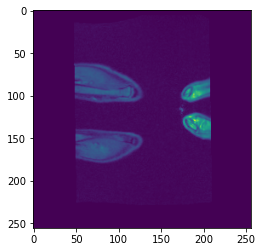

In [43]:
plt.imshow(dataset_real[0][:, :, 0])

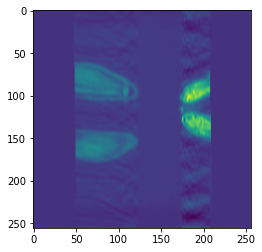

In [24]:
plt.imshow(u_sampled_data_2c[0][:, :, 0])

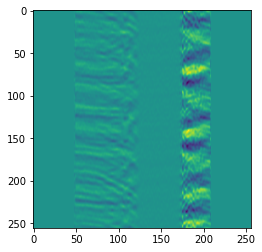

In [25]:
plt.imshow(u_sampled_data_2c[0][:, :, 1])

In [46]:
dataset_real.shape

(1, 256, 256, 1)

In [ ]:
def save_epoch_end(real, fake, path):
    plt.imsave(path, real, cmap='gray')
    plt.imsave(path, fake, cmap='gray')
        
    
    

In [114]:
def train(g_par, d_par, gan_model, dataset_real, u_sampled_data,  n_epochs, n_batch, n_critic, clip_val, n_patch, f=None):
    bat_per_epo = int(dataset_real.shape[0]/n_batch)
    half_batch = int(n_batch/2)

    for i in range(n_epochs):
        print('Epoch', i)
        for j in range(bat_per_epo):
            print('  Batch', j)
            # training the discriminator
            for k in range(n_critic):
                ix = np.random.randint(0, dataset_real.shape[0], half_batch)
            
                X_real = dataset_real[ix]
                
                
                y_real = np.ones((half_batch,n_patch,n_patch,1))
            
                ix_1 =  np.random.randint(0, u_sampled_data.shape[0], half_batch)
                X_fake  = g_par.predict(u_sampled_data[ix_1])
                
                y_fake = -np.ones((half_batch,n_patch,n_patch,1))
                X, y = np.vstack((X_real, X_fake)), np.vstack((y_real,y_fake))
                d_loss, accuracy = d_par.train_on_batch(X,y)
            
                for l in d_par.layers:
                    weights=l.get_weights()
                    weights=[np.clip(w, -clip_val,clip_val) for w in weights]
                    l.set_weights(weights)

            # training the generator
            ix = np.random.randint(0, dataset_real.shape[0], n_batch)
            X_r = dataset_real[ix]
            X_gen_inp = u_sampled_data[ix]
            y_gan = np.ones((n_batch,n_patch,n_patch,1))
                
            
            g_loss = gan_model.train_on_batch ([X_gen_inp], [y_gan, X_r, X_r])
            #f.write('>%d, %d/%d, d=%.3f, acc = %.3f,  w=%.3f,  mae=%.3f,  mssim=%.3f, g=%.3f' %(i+1, j+1, bat_per_epo, d_loss, accuracy, g_loss[1], g_loss[2], g_loss[3], g_loss[0]))
            #f.write('\n')
            print ('>%d, %d/%d, d=%.3f, acc = %.3f, g=%.3f' %(i+1, j+1, bat_per_epo, d_loss, accuracy, g_loss[0]))
        print('xreal')
        plt.imshow(X_real[0][:, :, 0], cmap='gray')
        plt.show()
        
        print('xfake')
        plt.imshow(X_fake[0][:, :, 0], cmap='gray')
        plt.show()
        #filename = './gen_weights_a5_%04d.h5' % (i+1)
            #reconstructed_img = plot_reconstructed_img(gan_model, X_gen_inp, X_r)
#         for layer in g_par.layers:
#             print(layer.get_output_at(0).get_shape().as_list())
        #g_par.save_weights(filename)
    #f.close()

Epoch 0
  Batch 0
>1, 1/1, d=-7.998, acc = 1.000, g=182.407
xreal


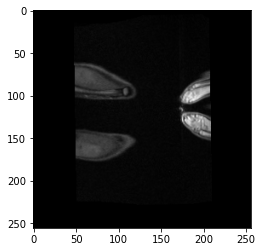

xfake


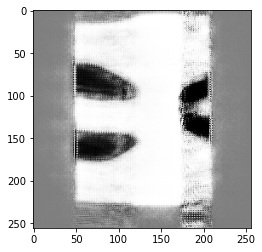

In [115]:
#f = open('./log_a5.txt', 'a') 
train(g_par, d_par, gan_model, dataset_real, u_sampled_data_2c, n_epochs, n_batch, n_critic, clip_val, n_patch)